In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt

import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name() if torch.cuda.is_available() else 'cpu')

# Random seed for reproduction
torch.manual_seed(594818632584900)

import warnings
warnings.filterwarnings("ignore", message="Attempting to run cuBLAS, but there was no current CUDA context!")

NVIDIA GeForce RTX 3050 6GB Laptop GPU


# PDE Setup

In [2]:
# Domain Setup 
xmin, xmax = 0, 2*np.pi     # Spatial domain
Nx = 512                    # Spatial resolution

Nt = 204                    # Temporal resolution
Tf = 1                      # Temporal final time

K = 1.0                     # Coupling constant 

print("\nIdentical Kuramoto Equation\n")
print(f"Domain Limits (xmin, xmax): {xmin:.2f}, {xmax:.2f}")
print("Number of Spatial Points (Nx):", Nx)
print(f"Final Time (Tf): {Tf:.2f} \n")


Identical Kuramoto Equation

Domain Limits (xmin, xmax): 0.00, 6.28
Number of Spatial Points (Nx): 512
Final Time (Tf): 1.00 



In [3]:
# for initalise
theta_init = torch.linspace(xmin, xmax, Nx, device=device).view(-1, 1)
t_init = torch.zeros_like(theta_init)

INITIAL = None
def initialise(theta):
    u0 = torch.zeros_like(theta)

    if INITIAL=='polynomial':
        mask = (theta >= (torch.pi/2)) & (theta <= (3*torch.pi/2))
        u0[mask] = 6 / (torch.pi**3) * ((3*torch.pi/2 - theta[mask]) * (theta[mask] - torch.pi/2))

        print("Polynomial initial condition: u0(x) = (6/pi^3) * ((3pi/2 - x) * (x - pi/2)) for x in [pi/2, 3pi/2]; 0 otherwise\n")
    
    elif INITIAL=='singular':
        def dirac_delta(x, a, epsilon=0.01):
            return torch.where(torch.abs(x-a) < epsilon, 1/(2*epsilon), 0)

        def heaviside(x):
            return torch.where(x>=0, 1, 0)
        
        u0[:] = ( 1/4 * (dirac_delta(theta, 3*torch.pi/4) + dirac_delta(theta, 5*torch.pi/4)) +
                1/2 * heaviside(theta - torch.pi/2) * (1 - heaviside(theta - 3*torch.pi/2)) )

        print("Dirac Singularities: u_0(x) = 1/4 * (delta_3pi/4 + delta_5pi/4) + 1/2 * X_[pi/2, 3pi/2]\n")

    elif INITIAL=='piecewise':
        mask = (theta >= (torch.pi/2)) & (theta <= (3*torch.pi/2))
        u0[mask]  = 2.0 / (3.0*torch.pi)
        u0[~mask] = 1.0 / (3.0*torch.pi)

        print("Piecewise initial condition: u0(x) = 2/(3pi) for x in [pi/2, 3pi/2]; 1/(3pi) otherwise\n")

    return u0.to(device)


def nonlocal_flux(model, theta, t, Nq=128):
    """
    For each collocation point (theta, t) approximate
       L[p](x,t) = -K * integral|0^(2pi)(sin(x - x') p(x', t) dx')
    using a Riemann sum.
    """
    # Qadrature points for x' in [xmin, xmax]
    theta_prime = torch.linspace(xmin, xmax, Nq, device=device).view(1, Nq)  # shape (1, Nq)
    delta_theta = xmax / Nq 

    # Expand to (N, Nq)
    theta_exp = theta.expand(-1, Nq)
    t_exp = t.expand(-1, Nq)
    
    inp_integ = torch.cat([theta_prime.repeat(theta.shape[0], 1).view(-1, 1),
                           t_exp.reshape(-1, 1)], dim=1)  # shape (N*Nq, 2)

    # Evaluate p
    rho_integ = model(inp_integ)  # shape (N*Nq, 1)
    rho_integ = rho_integ.view(theta.shape[0], Nq)  # shape (N, Nq)

    # Compute integrand: sin(x - x') * p(x',t)
    integrand = torch.sin(theta_exp - theta_prime.expand(theta_exp.shape)) * rho_integ  # shape (N, Nq)
    
    # Riemann sum
    integral = torch.sum(integrand, dim=1, keepdim=True) * delta_theta  # shape (N, 1)
    
    L = -K * integral
    return L


def pde_residual(model, theta, t):
    """
    compute the PDE residual:
         f = dp(x,t) + dx(L[p](x,t)*p(x,t)).
    """
    # For collocation points (theta, t) (each (N,1)) with theta.requires_grad=True and t.requires_grad=True,    
    theta.requires_grad_(True)
    t.requires_grad_(True)
    
    x = torch.cat([theta, t], dim=1)  # (N,2)
    rho = model(x)  # (N,1)

    rho_t = torch.autograd.grad(rho, t, grad_outputs=torch.ones_like(rho),
                                retain_graph=True, create_graph=True)[0]

    L_rho = nonlocal_flux(model, theta, t)
    u = L_rho * rho

    u_theta = torch.autograd.grad(u, theta, grad_outputs=torch.ones_like(u),
                                  retain_graph=True, create_graph=True)[0]
    
    # PDE residual: p_t + dx(u)
    f = rho_t + u_theta
    return f

# Network Architecture
### Simple FeedForward Neural Network

-> 1 input layer

-> 4 fully connected hidden layers; 64 neurons each

-> 1 output layer

In [4]:
class PINN(nn.Module):
    def __init__(self, activation, hidden_layers=4, neurons=64):
        super(PINN, self).__init__()

        self.input_layer = nn.Linear(2, neurons)
        self.hidden_layers = nn.ModuleList(
            [nn.Linear(neurons, neurons) for _ in range(hidden_layers)]
        )
        self.output_layer = nn.Linear(neurons, 1)
        
        self.activation = activation


    def forward(self, x):
        # x: (N,2) with x[:, 0]=x and x[:, 1]=t
        out = self.input_layer(x)
        out = self.activation(out)
        for layer in self.hidden_layers:
            out = layer(out)
            out = self.activation(out)
        out = self.output_layer(out)

        return out


def trainer(u_0, model, optimizer, theta_colloc, t_colloc, num_epochs=10240, plot_losses=False):
    torch.cuda.empty_cache()

    loss_history = []
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        
        # PDE residual loss
        f = pde_residual(model, theta_colloc, t_colloc)
        loss_pde = torch.mean(f**2)
        
        # Initial condition loss
        x_init = torch.cat([theta_init, t_init], dim=1)
        u_0_pred = model(x_init)
        loss_ic = torch.mean((u_0_pred - u_0)**2)
        
        # Total loss
        loss = loss_pde + loss_ic
        loss.backward()
        optimizer.step()
        
        loss_history.append(loss.item())
        
        if (epoch+1) % 512 == 0 or epoch == 0: 
            print(f"Epoch {epoch+1}, Total Loss: {loss.item():.6f}, PDE Loss: {loss_pde.item():.6f}, IC Loss: {loss_ic.item():.6f}")
    
    if plot_losses:
        plt.figure(figsize=(8, 4))
        plt.plot(loss_history)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training Loss")
        plt.show()
        
    return loss_history

# Prediction

Setup

In [5]:
# Input
theta_test = torch.linspace(xmin, xmax, Nx, device=device)
t_test = torch.linspace(0, Tf, Nt, device=device)

Theta, T = torch.meshgrid(theta_test, t_test, indexing='ij')  # Theta: (Nx, Nt), T: (Nx, Nt)

x_test = torch.cat([Theta.reshape(-1, 1), T.reshape(-1, 1)], dim=1)  # flattened


# Plot prediciton
t_test_np = t_test.cpu().numpy()
x_line = theta_test.cpu().numpy()
Theta_np = Theta.cpu().numpy()
T_np = T.cpu().numpy()
def plot(u_n, title, save=False, save_dir = rf"experiments/{INITIAL}_experiment_results"):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))        
    
    # --- Contour plot ---
    cp_plot = axes[0].contourf(Theta_np, T_np, u_n, levels=50, cmap='viridis')
    fig.colorbar(cp_plot, ax=axes[0], label='p(x,t)')
    axes[0].set_xlabel(r'$\theta$')
    axes[0].set_ylabel('t')
    axes[0].set_title(f'Contour: {title}')

    # --- Line plot ---
    time_snapshots = [0.0, Tf/4, Tf/2, 3*Tf/4, Tf]
    for ts in time_snapshots:
        idx = np.argmin(np.abs(t_test_np - ts))
        axes[1].plot(x_line, u_n[:, idx], label=f"t={t_test_np[idx]:.2f}")
    axes[1].set_xlabel(r'$\theta$')
    axes[1].set_ylabel(r'$\rho(\theta)$')
    axes[1].set_title(f'Line Plot: {title}')
    axes[1].legend(fontsize=8)

    if save:
        save_dir = save_dir
        os.makedirs(save_dir, exist_ok=True)
        exp_filename = f"solution_{''.join('_'.join(title.split(', ')).split(":"))}.png"
        fig.savefig(os.path.join(save_dir, exp_filename))
        plt.close(fig)
    
    else:
        plt.legend()
        plt.show()

In [6]:
# Collocation points in the interior: (x in [0, xmax], t in (0, Tf])
N_collocation = 1024
theta_colloc = torch.rand(N_collocation, 1, device=device) * xmax
t_colloc = torch.rand(N_collocation, 1, device=device) * Tf

### tanh, 4, 64, 5120, 1024, Polynomial

Layer (type:depth-idx)                   Param #
PINN                                     --
├─Linear: 1-1                            192
├─ModuleList: 1-2                        --
│    └─Linear: 2-1                       4,160
│    └─Linear: 2-2                       4,160
│    └─Linear: 2-3                       4,160
│    └─Linear: 2-4                       4,160
├─Linear: 1-3                            65
Total params: 16,897
Trainable params: 16,897
Non-trainable params: 0

Polynomial initial condition: u0(x) = (6/pi^3) * ((3pi/2 - x) * (x - pi/2)) for x in [pi/2, 3pi/2]; 0 otherwise

Epoch 1, Total Loss: 0.088085, PDE Loss: 0.000086, IC Loss: 0.087999
Epoch 512, Total Loss: 0.001844, PDE Loss: 0.000933, IC Loss: 0.000912
Epoch 1024, Total Loss: 0.000977, PDE Loss: 0.000620, IC Loss: 0.000358
Epoch 1536, Total Loss: 0.001989, PDE Loss: 0.001564, IC Loss: 0.000425
Epoch 2048, Total Loss: 0.000165, PDE Loss: 0.000089, IC Loss: 0.000075
Epoch 2560, Total Loss: 0.001099, PDE Loss: 0.

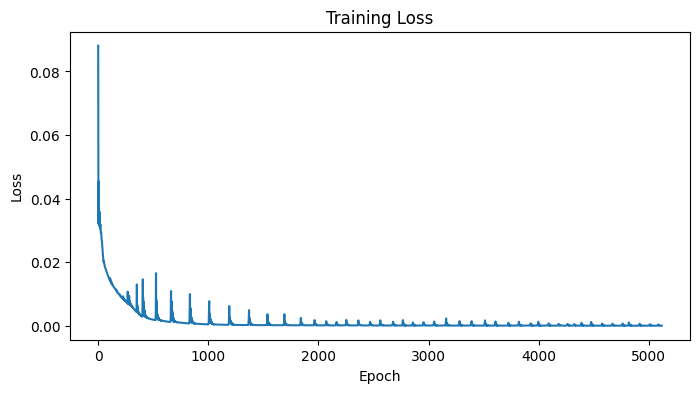

In [7]:
model = PINN(activation=torch.tanh, hidden_layers=4, neurons=64).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

print(summary(model), '\n')

INITIAL = 'polynomial'
u0 = initialise(theta_init)

losses = trainer(u0, model, optimizer, theta_colloc, t_colloc, num_epochs=5120, plot_losses=True)

(512, 204)


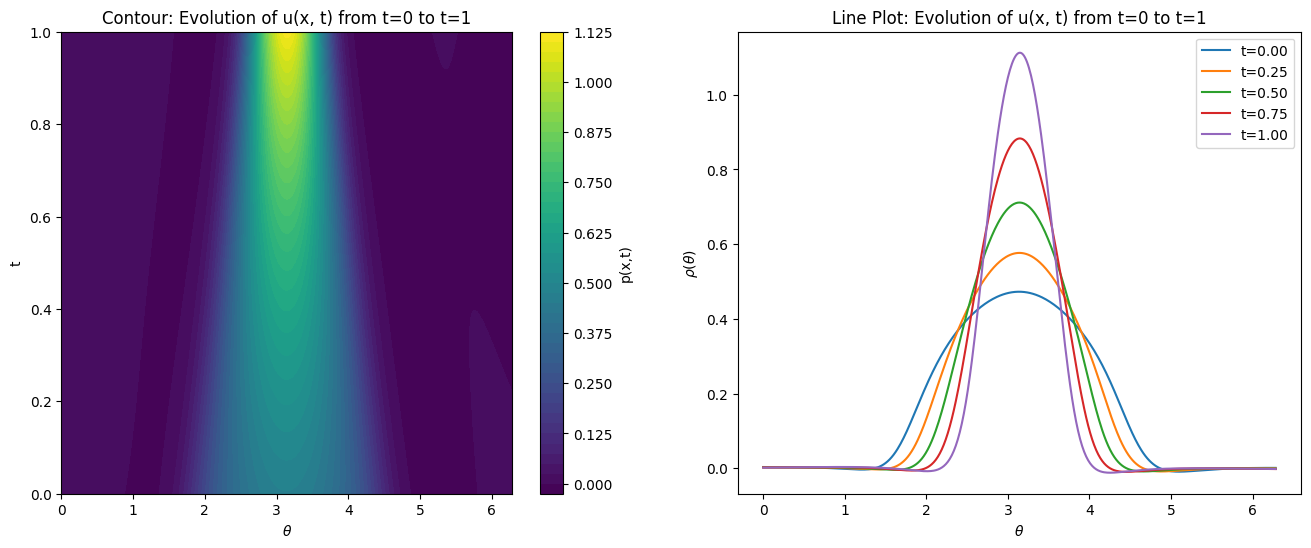

In [8]:
model.eval()
with torch.no_grad():
    u_n = model(x_test).reshape(Nx, Nt).cpu().numpy()
    print(u_n.shape)

plot(u_n, f"Evolution of u(x, t) from t=0 to t={Tf}")

##### GIF

In [9]:
def steps_plot(u_n, exact_file='u_ex.txt', xmin=0, xmax=2*np.pi, Tf=1):
    N = u_n.shape[0]
    x = np.linspace(xmin, xmax, N)
    
    time_steps = u_n.shape[1]    
    for t in range(time_steps):
        plt.figure(figsize=(8, 6))
        plt.clf()
        plt.xlabel(r'$\theta$')
        plt.ylabel(r'$rho(\theta)$')
        plt.title('PINN Simulation; IDKuramoto, Polynomial Initial Data')
        
        if os.path.exists(exact_file) and os.path.getsize(exact_file) > 0:
            ex_data = np.loadtxt(exact_file).transpose()
            plt.plot(x, ex_data[:, t], linestyle=":", marker="o", markersize=1,
                     markerfacecolor='none', label='Exact Solution')
        
        plt.plot(x, u_n[:, t], linestyle=":", marker="o", markersize=1,
                 markerfacecolor='none', label='PINN Solution')
        
        plt.legend()
        plt.savefig(rf"steps/{t}.png", bbox_inches="tight")
        plt.close()


# steps_plot(u_n, xmin=xmin, xmax=xmax, Tf=Tf)

# !python steps/gif.py

# 
------

# EXPERIMENTS

In [10]:
import time
import itertools
import json

### Grid

In [11]:
INITIAL = 'polynomial'
def run_experiments(activation_funcs, hidden_layers_neurons_list, epochs_list, collocation_points_list):
    u_ex = np.loadtxt("u_ex.txt").T  # (512, 205)
    
    results = []
    for (act_name, act_func), (hidden_layers, neurons), epochs, cp in itertools.product(
            activation_funcs, hidden_layers_neurons_list, epochs_list, collocation_points_list):
        
        torch.cuda.empty_cache()
        
        print(f"\nRunning experiment: activation={act_name}, hidden_layers={hidden_layers}, neurons={neurons}, epochs={epochs}, collocation_points={cp}")
        
        theta_colloc_exp = torch.rand(cp, 1, device=device) * xmax
        t_colloc_exp = torch.rand(cp, 1, device=device) * Tf
        
        model = PINN(activation=act_func, hidden_layers=hidden_layers, neurons=neurons).to(device)
        optimizer = optim.Adam(model.parameters(), lr=1e-3)
        
        u0 = initialise(theta_init)
        
        start_time = time.time()
        loss_history = trainer(u0, model, optimizer, theta_colloc_exp, t_colloc_exp, num_epochs=epochs)
        training_time = time.time() - start_time
        print(f"Training completed in {training_time:.2f} seconds.")
        
        model.eval()
        with torch.no_grad():
            u_n = model(x_test).reshape(u_ex.shape).cpu().numpy()
        
        deviation = np.mean((u_n - u_ex)**2)
        
        results.append({
            'activation': act_name,
            'hidden_layers, neurons': (hidden_layers, neurons),
            'epochs': epochs,
            'collocation_points': cp,
            'deviation': deviation,
            'training_time': training_time,

        }); 
    
    fastest = sorted(results, key=lambda x: x["training_time"])
    best = sorted(results, key=lambda x: x["deviation"])
    output_data = {
        "Fastest": {
            "description": "Results sorted by Training time",
            "results": fastest
        },
    
        "Best": {
            "description": "Results sorted by deviation",
            "results": best
        }
    }
    output_file = rf"experiments/{INITIAL}_experiment_results/experiment_results.json"
    with open(output_file, "w") as f:
        json.dump(output_data, f, indent=4)

    return fastest, best


# -------------------------------------------- #
# Parameter grid 

# Custom Activation (if any)

activation_funcs = [
    ("tanh", torch.tanh),
    ("sin", lambda x: torch.sin(x))
    #("custom_activation", lambda x: custom_activation(x))
]
hidden_layers_neurons_list = [
    (4, 64),
    (4, 128),
    (6, 128),
    (6, 256),
    (8, 256),
]
epochs_list = [2048, 4096, 5120, 10240]
collocation_points_list = [1024, 2048]

# fastest, best = run_experiments(activation_funcs, hidden_layers_neurons_list, epochs_list, collocation_points_list)


### Comparisons

In [12]:
# load json data
def get_unique_key(exp):
    return (exp["activation"], 
            tuple(exp["hidden_layers, neurons"]), 
            exp["epochs"], 
            exp["collocation_points"])

with open(rf"experiments/{INITIAL}_experiment_results/experiment_results.json", "r") as f:
    data = json.load(f)

fastest = data["Fastest"]["results"]
best = data["Best"]["results"]

experiments = {}
for exp in fastest + best:
    key = get_unique_key(exp)
    experiments[key] = exp
    
exp_list = list(experiments.values())

In [13]:
# Observations from experiment_results.json

# Observation 1: To capture more accurate predicitions (less l2 errors) using more colloation points 
# better results with more epochs or wider networks

# Observation 2: Wider, denser network perform better with more collocation points

minmax normalized composite score for balancing minimal and optimal

In [14]:
training_times = [exp["training_time"] for exp in exp_list]
deviations = [exp["deviation"] for exp in exp_list]
min_time, max_time = min(training_times), max(training_times)
min_dev, max_dev = min(deviations), max(deviations)

def normalize(x, min_val, max_val):
    return (x - min_val) / (max_val - min_val) if max_val != min_val else 0

for exp in exp_list:
    norm_time = normalize(exp["training_time"], min_time, max_time)
    norm_dev = normalize(exp["deviation"], min_dev, max_dev)
    exp["composite_score"] = norm_time + norm_dev

top_10 = sorted(exp_list, key=lambda x: x["composite_score"])[:10]
print("Top 10 experiments based on composite score:")
for exp in top_10:
    print(exp)


Top 10 experiments based on composite score:
{'activation': 'tanh', 'hidden_layers, neurons': [4, 64], 'epochs': 2048, 'collocation_points': 1024, 'deviation': 0.0001228807900057513, 'training_time': 34.676011085510254, 'composite_score': 0.0006587120619260076}
{'activation': 'sin', 'hidden_layers, neurons': [4, 64], 'epochs': 2048, 'collocation_points': 1024, 'deviation': 7.861544949624488e-05, 'training_time': 37.933730125427246, 'composite_score': 0.0014319737939505663}
{'activation': 'tanh', 'hidden_layers, neurons': [4, 128], 'epochs': 2048, 'collocation_points': 1024, 'deviation': 7.747055319846629e-05, 'training_time': 58.79557514190674, 'composite_score': 0.008692520718273275}
{'activation': 'tanh', 'hidden_layers, neurons': [4, 64], 'epochs': 4096, 'collocation_points': 1024, 'deviation': 5.2962631952024245e-05, 'training_time': 67.24257802963257, 'composite_score': 0.011435705736845141}
{'activation': 'sin', 'hidden_layers, neurons': [4, 128], 'epochs': 2048, 'collocation_poi

rank aggregation for optimal

In [15]:
sorted_by_time = sorted(exp_list, key=lambda x: x["training_time"])
for rank, exp in enumerate(sorted_by_time, start=1):
    exp["time_rank"] = rank

sorted_by_dev = sorted(exp_list, key=lambda x: x["deviation"])
for rank, exp in enumerate(sorted_by_dev, start=1):
    exp["dev_rank"] = rank

for exp in exp_list:
    exp["aggregate_rank"] = exp["time_rank"] + exp["dev_rank"]

top_10 = sorted(exp_list, key=lambda x: x["aggregate_rank"])[:10]
print("Top 10 experiments based on rank aggregation:")
for exp in top_10:
    print(exp)

Top 10 experiments based on rank aggregation:
{'activation': 'sin', 'hidden_layers, neurons': [4, 64], 'epochs': 4096, 'collocation_points': 1024, 'deviation': 4.3711407677040294e-05, 'training_time': 75.92699980735779, 'composite_score': 0.01438638930034626, 'time_rank': 8, 'dev_rank': 3, 'aggregate_rank': 11}
{'activation': 'tanh', 'hidden_layers, neurons': [4, 64], 'epochs': 5120, 'collocation_points': 1024, 'deviation': 4.410067502737426e-05, 'training_time': 86.39026832580566, 'composite_score': 0.018035799180499617, 'time_rank': 10, 'dev_rank': 4, 'aggregate_rank': 14}
{'activation': 'tanh', 'hidden_layers, neurons': [4, 128], 'epochs': 4096, 'collocation_points': 1024, 'deviation': 4.232997382630036e-05, 'training_time': 113.4130265712738, 'composite_score': 0.027438175792011583, 'time_rank': 13, 'dev_rank': 1, 'aggregate_rank': 14}
{'activation': 'tanh', 'hidden_layers, neurons': [4, 64], 'epochs': 10240, 'collocation_points': 1024, 'deviation': 4.234831232206919e-05, 'training

pareto front domination for minimal


In [16]:
def is_dominated(exp, others):
    for other in others:
        if (other["training_time"] <= exp["training_time"] and
            other["deviation"] <= exp["deviation"] and
            (other["training_time"] < exp["training_time"] or other["deviation"] < exp["deviation"])):
            return True
    return False

pareto_front = [exp for exp in exp_list if not is_dominated(exp, exp_list)]
print("Pareto front experiments:")
for exp in pareto_front:
    print(exp)

Pareto front experiments:
{'activation': 'tanh', 'hidden_layers, neurons': [4, 64], 'epochs': 2048, 'collocation_points': 1024, 'deviation': 0.0001228807900057513, 'training_time': 34.676011085510254, 'composite_score': 0.0006587120619260076, 'time_rank': 1, 'dev_rank': 62, 'aggregate_rank': 63}
{'activation': 'sin', 'hidden_layers, neurons': [4, 64], 'epochs': 2048, 'collocation_points': 1024, 'deviation': 7.861544949624488e-05, 'training_time': 37.933730125427246, 'composite_score': 0.0014319737939505663, 'time_rank': 2, 'dev_rank': 48, 'aggregate_rank': 50}
{'activation': 'tanh', 'hidden_layers, neurons': [4, 128], 'epochs': 2048, 'collocation_points': 1024, 'deviation': 7.747055319846629e-05, 'training_time': 58.79557514190674, 'composite_score': 0.008692520718273275, 'time_rank': 3, 'dev_rank': 47, 'aggregate_rank': 50}
{'activation': 'tanh', 'hidden_layers, neurons': [4, 64], 'epochs': 4096, 'collocation_points': 1024, 'deviation': 5.2962631952024245e-05, 'training_time': 67.2425

Sequential match for fun

In [17]:
fastest_top20 = data["Fastest"]["results"][:20]
best_top20 = data["Best"]["results"][:20]

fastest_keys = [get_unique_key(exp) for exp in fastest_top20]
best_keys = [get_unique_key(exp) for exp in best_top20]

matches_from_best = []
for idx_best, key in enumerate(best_keys):
    if key in fastest_keys:
        idx_fastest = fastest_keys.index(key)
        matches_from_best.append((idx_best, idx_fastest, key))

print("Matches: Experiments from top 20 Best found in top 20 Fastest:")
for idx_best, idx_fastest, key in matches_from_best:
    print(f"Best index: {idx_best}, Fastest index: {idx_fastest}, Experiment key: {key}")

matches_from_fastest = []
for idx_fastest, key in enumerate(fastest_keys):
    if key in best_keys:
        idx_best = best_keys.index(key)
        matches_from_fastest.append((idx_fastest, idx_best, key))

print("\nMatches: Experiments from top 20 Fastest found in top 20 Best:")
for idx_fastest, idx_best, key in matches_from_fastest:
    print(f"Fastest index: {idx_fastest}, Best index: {idx_best}, Experiment key: {key}")


Matches: Experiments from top 20 Best found in top 20 Fastest:
Best index: 0, Fastest index: 12, Experiment key: ('tanh', (4, 128), 4096, 1024)
Best index: 2, Fastest index: 7, Experiment key: ('sin', (4, 64), 4096, 1024)
Best index: 3, Fastest index: 9, Experiment key: ('tanh', (4, 64), 5120, 1024)
Best index: 8, Fastest index: 18, Experiment key: ('sin', (4, 64), 4096, 2048)
Best index: 15, Fastest index: 11, Experiment key: ('sin', (4, 64), 5120, 1024)

Matches: Experiments from top 20 Fastest found in top 20 Best:
Fastest index: 7, Best index: 2, Experiment key: ('sin', (4, 64), 4096, 1024)
Fastest index: 9, Best index: 3, Experiment key: ('tanh', (4, 64), 5120, 1024)
Fastest index: 11, Best index: 15, Experiment key: ('sin', (4, 64), 5120, 1024)
Fastest index: 12, Best index: 0, Experiment key: ('tanh', (4, 128), 4096, 1024)
Fastest index: 18, Best index: 8, Experiment key: ('sin', (4, 64), 4096, 2048)


### Comparison Plots

594818632584900


tanh, (4, 64), 5120, 1024
Polynomial initial condition: u0(x) = (6/pi^3) * ((3pi/2 - x) * (x - pi/2)) for x in [pi/2, 3pi/2]; 0 otherwise

Epoch 1, Total Loss: 0.072993, PDE Loss: 0.000077, IC Loss: 0.072916
Epoch 512, Total Loss: 0.000994, PDE Loss: 0.000503, IC Loss: 0.000492
Epoch 1024, Total Loss: 0.001255, PDE Loss: 0.000928, IC Loss: 0.000327
Epoch 1536, Total Loss: 0.000301, PDE Loss: 0.000180, IC Loss: 0.000121
Epoch 2048, Total Loss: 0.000612, PDE Loss: 0.000475, IC Loss: 0.000137
Epoch 2560, Total Loss: 0.000059, PDE Loss: 0.000023, IC Loss: 0.000036
Epoch 3072, Total Loss: 0.000048, PDE Loss: 0.000017, IC Loss: 0.000032
Epoch 3584, Total Loss: 0.000035, PDE Loss: 0.000014, IC Loss: 0.000022
Epoch 4096, Total Loss: 0.000040, PDE Loss: 0.000020, IC Loss: 0.000021
Epoch 4608, Total Loss: 0.000024, PDE Loss: 0.000011, IC Loss: 0.000014
Epoch 5120, Total Loss: 0.000051, PDE Loss: 0.000028, IC Loss: 0.000023
Training completed in 95.03 seconds.
594818632584900




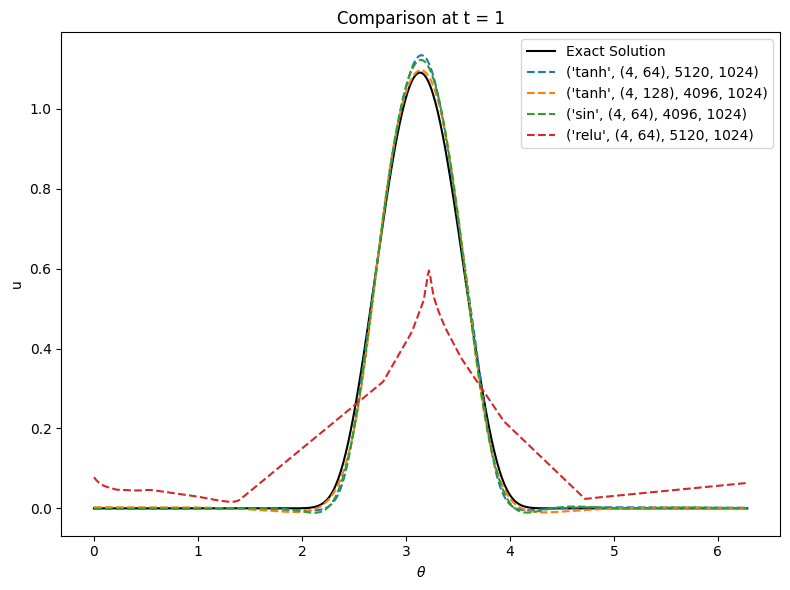

In [18]:
# Comparisons
INITIAL = 'polynomial'

architectures = [
    {"activation_name": "tanh", "activation": torch.tanh, "hln": (4, 64), "epochs": 5120, "collocation_points": 1024},
    {"activation_name": "tanh", "activation": torch.tanh, "hln": (4, 128), "epochs": 4096, "collocation_points": 1024},
    {"activation_name": "sin", "activation": lambda x: torch.sin(x), "hln": (4, 64), "epochs": 4096, "collocation_points": 1024},
    {"activation_name": "relu", "activation": torch.relu, "hln": (4, 64), "epochs": 5120, "collocation_points": 1024}
]

# ------------------------------------------------------------------------------ #

u_ex = np.loadtxt("u_ex.txt").T  # shape: (205, 512)

os.makedirs(rf"experiments/comparison/{INITIAL}/loss", exist_ok=True)
os.makedirs(rf"experiments/comparison/{INITIAL}/plots", exist_ok=True)

predictions = []
for i, arch in enumerate(architectures):
    torch.cuda.empty_cache()

    exp = f"{arch['activation_name']}, {arch['hln']}, {arch['epochs']}, {arch['collocation_points']}"
    print(f"\n\n{exp}")
    
    theta_colloc_exp = torch.rand(arch["collocation_points"], 1, device=device) * xmax
    t_colloc_exp = torch.rand(arch["collocation_points"], 1, device=device) * Tf
    
    model = PINN(activation=arch["activation"], 
                 hidden_layers=arch["hln"][0], 
                 neurons=arch["hln"][1]).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    u0 = initialise(theta_init)
    
    start_time = time.time()
    loss_history = trainer(u0, model, optimizer, theta_colloc_exp, t_colloc_exp, num_epochs=arch["epochs"])
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds.")

    # Loss history
    plt.figure(figsize=(8, 4))
    plt.plot(loss_history, 'b-')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Loss History: {exp}")
    plt.tight_layout()
    plt.savefig(rf"experiments/comparison/{INITIAL}/loss/loss_history_{'_'.join(exp.split(", "))}.png")
    plt.close()
    
    # Evaluate
    model.eval()
    with torch.no_grad():
        u_pred = model(x_test).reshape(u_ex.shape).cpu().numpy()
    predictions.append(u_pred)
    plot(u_pred, f"{exp}", save=True, save_dir=rf"experiments/comparison/{INITIAL}/plots")
         
# Comparison plot at t = Tf
plt.figure(figsize=(8, 6))
plt.plot(x_line, u_ex[:, -1], 'k-', label="Exact Solution")
for i, u_pred in enumerate(predictions):
    plt.plot(x_line, u_pred[:, -1], '--', label=f"{architectures[i]['activation_name'], architectures[i]['hln'], architectures[i]['epochs'], architectures[i]['collocation_points']}")
plt.xlabel(r'$\theta$')
plt.ylabel('u')
plt.title(f"Comparison at t = {Tf}")
plt.legend()
plt.tight_layout()
plt.savefig(rf"experiments/comparison/{INITIAL}/plots/comparison_Tf.png")
plt.show()

Time v L2 Error

In [19]:
def plot_tt_l2(archs, name):
    def experiment_matches(exp, arch):
        return (
            exp["activation"] == arch["activation"] and
            exp["hidden_layers, neurons"] == arch["hidden_layers, neurons"] and
            exp["epochs"] == arch["epochs"] and
            exp["collocation_points"] == arch["collocation_points"]
        ) 
    results = best
    filtered_results = [
        res for res in results 
        if any(experiment_matches(res, arch) for arch in archs)
    ]
    training_times = [res["training_time"] for res in filtered_results]
    l2_errors = [np.sqrt(res["deviation"]) for res in filtered_results]

    labels = [
        f"{res['activation']}, HL: {res['hidden_layers, neurons']}, epochs: {res['epochs']}, CP: {res['collocation_points']}"
        for res in filtered_results
    ]

    plt.figure(figsize=(10, 6))
    plt.scatter(training_times, l2_errors, color='blue')
    for i, label in enumerate(labels):
        plt.annotate(label, (training_times[i], l2_errors[i]), textcoords="offset points", xytext=(5, 5), ha='left', fontsize=8)
    plt.xlabel("Training Time (seconds)")
    plt.ylabel("L2 Error")
    plt.title("Training Time vs. L2 Error")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(rf"experiments/comparison/{INITIAL}/plots/comparison_{name}.png")
    plt.show()

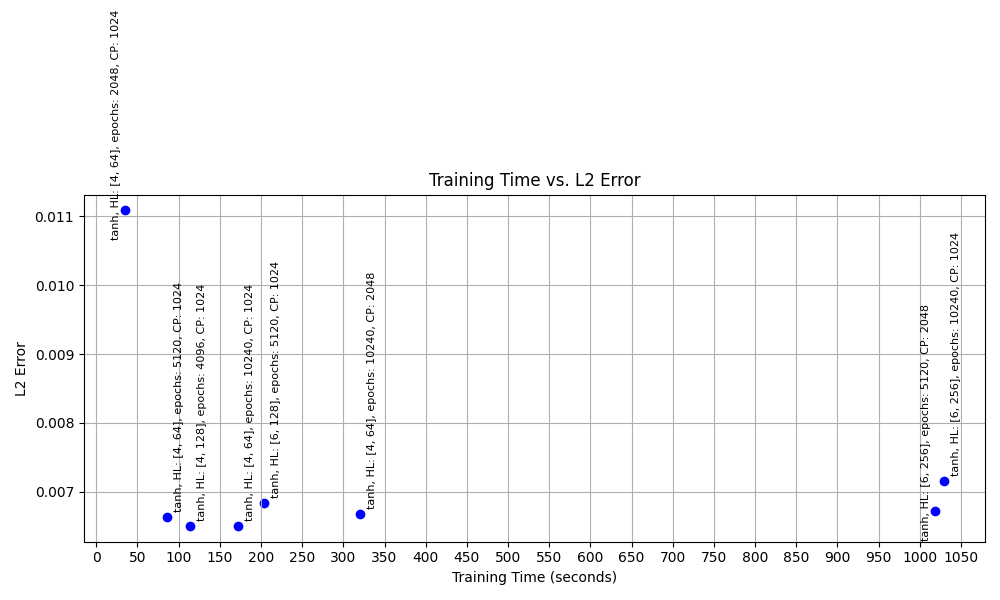

In [ ]:
archs_l2plot = [
    # minimal architecture, Best + variations (epochs, collocation points)
    {"activation": "tanh", "hidden_layers, neurons": [4, 64], "epochs": 2048, "collocation_points": 1024},
    {"activation": "tanh", "hidden_layers, neurons": [4, 64], "epochs": 5120, "collocation_points": 1024},

    {"activation": "tanh", "hidden_layers, neurons": [4, 64], "epochs": 10240, "collocation_points": 1024},
    {"activation": "tanh", "hidden_layers, neurons": [4, 64], "epochs": 10240, "collocation_points": 2048}, #Best for 2048

    # Extended architecture, Best configuration
    {"activation": "tanh", "hidden_layers, neurons": [4, 128], "epochs": 4096, "collocation_points": 1024},
    
    {"activation": "tanh", "hidden_layers, neurons": [6, 128], "epochs": 5120, "collocation_points": 1024},
    
    {"activation": "tanh", "hidden_layers, neurons": [6, 256], "epochs": 5120, "collocation_points": 2048},
    {"activation": "tanh", "hidden_layers, neurons": [6, 256], "epochs": 10240, "collocation_points": 1024} 
]

plot_tt_l2(archs_l2plot, "tan_archs")

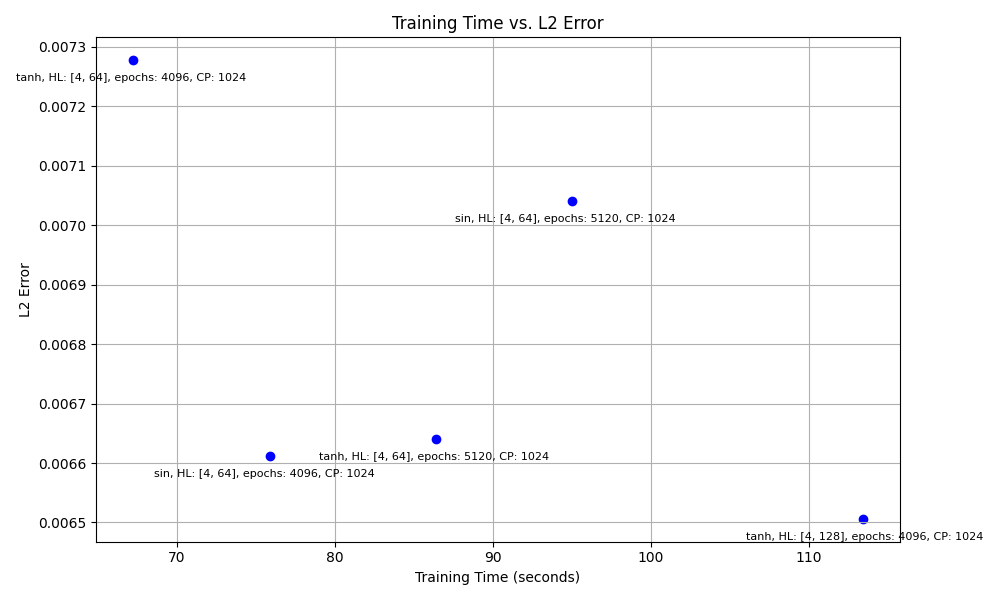

In [ ]:
archs_act_plot = [
    {"activation": "tanh", "hidden_layers, neurons": [4, 64], "epochs": 4096, "collocation_points": 1024}, 
    {"activation": "tanh", "hidden_layers, neurons": [4, 64], "epochs": 5120, "collocation_points": 1024}, #Best
    {"activation": "tanh", "hidden_layers, neurons": [4, 128], "epochs": 4096, "collocation_points": 1024}, #MAYBE overfitting


    {"activation": "sin", "hidden_layers, neurons": [4, 64], "epochs": 4096, "collocation_points": 1024}, #Best
    {"activation": "sin", "hidden_layers, neurons": [4, 64], "epochs": 5120, "collocation_points": 1024},
]

plot_tt_l2(archs_act_plot, "tan_sin")

#
---

Testing


In [22]:
INITIAL = 'singular'
def _run_experiments(activation_funcs, hidden_layers_list, neurons_list, epochs_list, collocation_points_list): 
    for (act_name, act_func), hidden_layers, neurons, epochs, cp in itertools.product(
            activation_funcs, hidden_layers_list, neurons_list, epochs_list, collocation_points_list):
            
        torch.cuda.empty_cache()
        
        print(f"\nRunning experiment: activation={act_name}, hidden_layers={hidden_layers}, neurons={neurons}, epochs={epochs}, collocation_points={cp}")
        
        theta_colloc_exp = torch.rand(cp, 1, device=device) * xmax
        t_colloc_exp = torch.rand(cp, 1, device=device) * Tf
        
        model = PINN(activation=act_func, hidden_layers=hidden_layers, neurons=neurons).to(device)
        optimizer = optim.Adam(model.parameters(), lr=1e-3)
        
        u0 = initialise(theta_init)
        
        start_time = time.time()
        loss_history = trainer(u0, model, optimizer, theta_colloc_exp, t_colloc_exp, num_epochs=epochs)
        end_time = time.time()
        training_time = end_time - start_time
        print(f"Training completed in {training_time:.2f} seconds.")
        
        model.eval()
        with torch.no_grad():
            u_n = model(x_test).reshape(Nx, Nt).cpu().numpy()

        plot(u_n, f"{act_name}, HL:{hidden_layers}, N:{neurons}, epochs:{epochs}, cp:{cp}", save=True)
        

# -------------------------------------- #
# Parameter grid.

# Custom Activation (if any)
def mexican_hat_wavelet(x, sigma=1):
    coefficient = 2 / ((3*sigma)**0.5 * torch.pi**0.25)
    return coefficient * (1 - (x/sigma)**2) * torch.exp(-x**2 / (2 * sigma**2))

activation_funcs = [
    # ("tanh", torch.tanh),
    ("sin", lambda x: torch.sin(x)),
    # ("mexican_hat_wavelet", lambda x: mexican_hat_wavelet(x))
    #("custom_activation", lambda x: custom_activation(x))
]
hidden_layers_list = [2]
neurons_list = [128]
epochs_list = [2048, 5120]
collocation_points_list = [2048]

# _run_experiments(activation_funcs, hidden_layers_list, neurons_list, epochs_list, collocation_points_list)